# Stable Diffusion for Webcomic Art Generation

This project aims to implement "stable diffusion" for image generation in order to assist artists in iterating upon concepts more quickly.

This project was built leveraging the Huggingface Diffusers library, which provides a flexible and easy-to-use implementation of stable diffusion. This allowed us to quickly and efficiently implement the algorithm, and focus on developing features and improvements specifically tailored to the needs of artists.

More information about Stable Diffusion can be found in the analysis document -- this notebook focuses on application. Analysis of the results can be seen at the bottom of this document.

## Conditional Image Generation

The most famous application for Stable Diffusion is "Conditional Image Generation", which allows you to input a prompt and receive an image which matches the prompt. Inutitively, you can think of this like a sort of "reverse image captioning", where you provide the caption rather than the image.

Huggingface Diffusers makes this process very easy, although you still need a relatively powerful machine to use it. To see an example of this, see the below

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|███████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.02it/s]


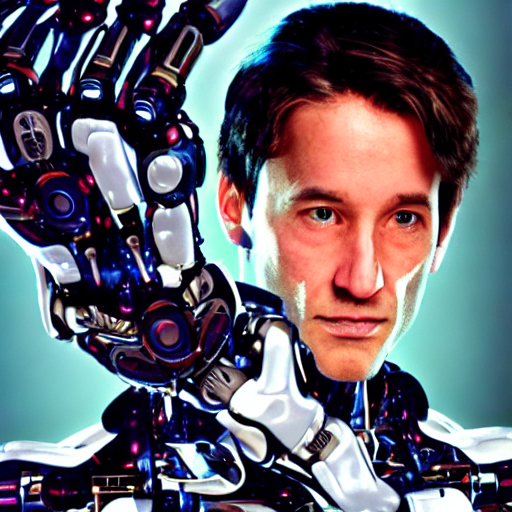

In [1]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "./stable-diffusion-v1-5",
    revision="fp16",
    torch_dtype=torch.float16
)

pipe = pipe.to("cuda")

prompt = "Robotic Cyborg Johns Hopkins"
image = pipe(prompt).images[0]  
image

Extremely simple! The majority of the code for this project is therefore spent around infrastructure to make this easy to use.

## Image to Image Diffusion

Stable Diffusion allows for "Image to Image Generation", which uses the latent representation of a "Source" image instead of a random noise starting point. This allows for relatively simple drawings to be used as starting points, with the more time-consuming intermediate technical steps to be completed by stable diffusion. For a use-case example, see the below

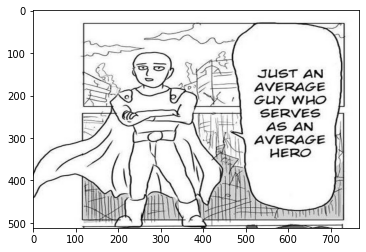

In [2]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# let's download an initial image
url = "https://cdn.discordapp.com/attachments/844700472820760576/1043294063060848743/MicrosoftTeams-image.png"
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))
plt.imshow(init_image)

100%|███████████████████████████████████████████████████████████████| 42/42 [00:35<00:00,  1.18it/s]


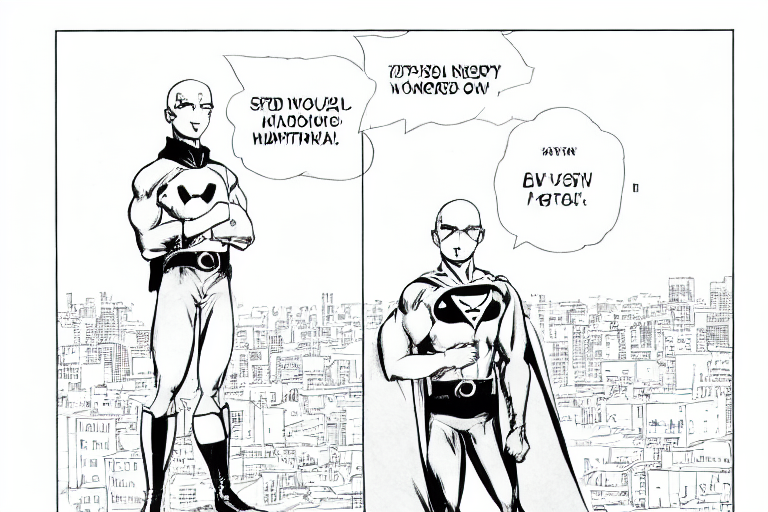

In [3]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline

# load the pipeline
device = "cuda"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "./stable-diffusion-v1-5", revision="fp16", torch_dtype=torch.float16
).to(device)

prompt = "a manga panel of a bald superhero wearing a belt, a cape, and boots, standing in front of a city landscape, extremely detailed"
images = pipe(prompt=prompt, image=init_image, strength=0.85, guidance_scale=7.5).images
images[0]

## How to use our code

Our code is a relatively straightforward implementation of the above. By default, the code will perform conditional image generation. If the path to an example image is passed, it will switch to image-to-image generation. That is to say:

**Conditional Generation**
```
python diffusion.py --prompt "A dinosaur on top of a skyscraper"
```

**Img2Img Generation**
```
python diffusion.py --prompt "A dinosaur on top of a skyscraper" --img /path/to/image
```

## Limitations

The original vision for this project was to include dreambooth and textual inversion. However, due to VRAM constraints, textual inversion was impossible unless more compute power was obtained. Dreambooth is possible to get working with a less powerful graphics card, but requires at least 25 GB of RAM on the machine used for training, which was also a computational bottleneck. In addition, both of these work by creating a new version of the pretrained weights, which would have been a bit heavy for the already large docker container. 

The dreambooth training

If you'd like to try dreambooth, you can use the "mount folder" method of building the docker, and run the "dreambooth.sh" script as follows, after editing the script as needed.

```
sh scripts/dreambooth.sh
```

From there, you can change the string "stable-diffusion-v-1-5" with the name of your adjusted model.

## Analysis and Findings

Stable Diffusion [1] is an image generation model which uses diffusion [2] in order to generate images based on a text prompt. Unlike other well-known diffusion models, for example DALL-E 2 [3], the diffusion process in stable diffusion is performed in the smaller latent space of an image embedding, rather than the larger but more intuitive image space. The primary benefit of this is that Stable Diffusion achieves competitive results despite being viable to run on consumer GPUs, and are therefore a viable technology for artists who want to generate images, rather than researchers with huge compute clusters.

Concept art generation is time consuming and expensive. A single concept made by a single person often can take upwards of 50 hours to create [4], leading to approximate costs of $50,000 per concept at standard professional rates. While the image generation quality provided by stable diffusion is impressive, it is not enough to "replace" concept artists (nor would that be the goal of such a model). However, compared to human artists, even single-gpu stable diffusion interest is many orders of magnitude faster. The output of this repository will complete in about ~1 minute, so a concept artist could use this tool to generate hundreds of ideas, select a starting point, and get a substantial "head start" on the concept ideation process compared to standard concept art workflows. 

There are three concepts which build on top of vanilla stable diffusion which have the potential to help artists: image-to-image, textual inversion, and dreambooth. While code for two of these (img2img and dreambooth) are included in this repository, dreambooth (and textual inversion) required a bit more computational power than my machine had (either for VRAM or for RAM). Nonetheless, these concepts are worth exploring, so they will be described below.

Image to Image generation with diffusion models is relatively simple [7]. Instead of starting from random noise, it simply starts from a source image (or an embedding of a source image), which allows it to "complete" a damaged or half-completed image. This is useful for the standard auto-encoder-like [8] use cases: inpainting, denoising, superresolution, etc. However, for artists, this allows the user to draw a very minimal drawing, attach a prompt, and get a result which could otherwise take hours to make. This has obvious applications for accelerating concept-art and comic-art-workflows.

![](https://static.simonwillison.net/static/2022/stable-diffusion-img2img.png)

![](https://static.simonwillison.net/static/2022/stable-diffusion-1.jpg)

(Images courtesy of [9]).

Textual Inversion [5] is a technique which "micro fine-tunes" the stable diffusion weights in order to "teach" stable diffusion a new concept. That is to say, we can teach a new object to stable diffusion as a new token \<S> such that it can learn to generate more images of that particular task. This works by creating a new token, learning a new embedding for that token, and then conditions the generation on a variety of context templates (e.g. "a photo of \<S>"). 

Dreambooth [6] by contrast, is a technique which "micro fine-tunes" the stable diffusion weights in order to generate more images of a particular subject in novel situations. The difference between this and textual inversion is subtle; both are few-shot fine-tuning techniques to generate more of something you are interested in. The intuition here is that Dreambooth puts an *instance* of a concept into novel situations, whereas Textual Inversion puts a *concept* into novel situation. These two concepts can be combined, and leads to good results.

However, textual inversion and dreambooth are still relatively computationally expensive operations. To give an intuition as to why, consider that stable diffusion can run (with some difficulty) on 8GB GPUs. In order to fine tune the weights of the model, you will need to use some sort of optimizer. Most optimizers require four copies of the model in video memory - weights, gradients, average gradients, and squared gradients. Some small optimizations can be used to reduce the use of video memory, but the immutable cost of optimizing a network is much higher than just using it for inference.

Overall, Stable Diffusion has great potential to make life easier for concept artists. Generating ideas can be done much quicker, on the order of minutes rather than hours, and relatively accessible computers can be used to run it, making it more affordable compared to an expensive webservice. While textual inversion and dreambooth require expensive gpus, as technology evolves these two things will move in each others' direction: gpus will become cheaper as the technology improves, and models will achieve similar performance with fewer parameters. All of this can be done with extremely minimal external data collect (3-5 examples per concept, both for dreambooth and textual inversion), and a full-scale fine-tune is largely unnecessary unless you are implementing this at scale for many artists, or you care about the output beyond them being a launching pad for artists. While the technology may be controversial in some artists circles, with enough time I have some faith that these tools will help artists far more than they hurt them.

## References

[1] Rombach, Robin, et al. "High-resolution image synthesis with latent diffusion models." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2022.

[2] Sohl-Dickstein, Jascha, et al. "Deep unsupervised learning using nonequilibrium thermodynamics." International Conference on Machine Learning. PMLR, 2015.

[3] Ramesh, Aditya, et al. "Hierarchical text-conditional image generation with clip latents." arXiv preprint arXiv:2204.06125 (2022).

[4] Veresockaya, Svetlana. "How Much Does Concept Art Cost?" https://kevurugames.com/blog/how-much-does-concept-art-cost-s-simple-formula-to-estimate-the-project (2020).

[5] Gal, Rinon, et al. "An image is worth one word: Personalizing text-to-image generation using textual inversion." arXiv preprint arXiv:2208.01618 (2022).

[6] Ruiz, Nataniel, et al. "Dreambooth: Fine tuning text-to-image diffusion models for subject-driven generation." arXiv preprint arXiv:2208.12242 (2022).

[7] Saharia, Chitwan, et al. "Palette: Image-to-image diffusion models." ACM SIGGRAPH 2022 Conference Proceedings. 2022.

[8] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).

[9] Willison, Simon. "Stable Diffusion is a really big deal." https://simonwillison.net/2022/Aug/29/stable-diffusion/ (2022).